In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

from bimmquant.utils import tools
from bimmquant.models.bimm2d import BIMM2D
from bimmquant.data.experimental_data import SOCPristineFor2Dmodel

In [2]:
#Set random seed
random_seed = 123
torch.manual_seed(random_seed)

In [3]:
%load_ext tensorboard

# Quantification and segmentation using the 2D BIMM - *experimental data*

In this notebook, we fit the blurred interface mixture model (BIMM) to a 3D ptogopraphy dataset of fuel cell electrode [1]. This is the "pristine" dataset refered to in [our paper](https://arxiv.org/abs/2009.07218) [2]. The data from the "annealed" sample is not publically available. 

We use the 2D version of the model, thus using both intensities and gradient magnitdes of the data. This makes it possible to quantify interface areas and image resolution, and improves segmentation for data with more than two phases. 

Note that the results for the quantification (Section 4 below) won't agree perfectly with the numbers reported in the paper, as we here only run the code once while for the paper, the code was run 30 times to calculate confidence intervals of the results. 

[1] De Angelis, S., Jørgensen, P. S., Tsai Rho, E., Holler, M., Kreka, K., Bowen, J. R. (2018). *Three dimensional characterization of nickel coarsening in solid oxide cells via ex-situ ptychographic nano-tomography* (Version 1.0) [Data set]. http://doi.org/10.5281/zenodo.1040274

[2] Brenne, E. O., Dahl, V. A., & Jørgensen, P. S. (2020). *A Physical Model for Microstructural Characterization and Segmentation of 3D Tomography Data*. [arXiv:2009.07218](https://arxiv.org/abs/2009.07218).

## Workflow

1. Download the data
1. Investigate 1D and 2D histograms
1. Fit the 2-D BIMM
1. Quantification: Volume fractions, interface areas ++
1. Segmentation of a small data volume

## 1. Download the data

The dataset can be found here: http://dx.doi.org/10.5281/zenodo.1040274

The file size is 234.7 MB, and contains 500 `.tiff`-images of size 501 x 501 voxels, with voxel size 18.4 nm.

Download the folder `SOCPristineTiffs.zip`, extract it and place **all .tif files** it in the folder `/example_data/experimental_data/SOCPristineTiffs/`.

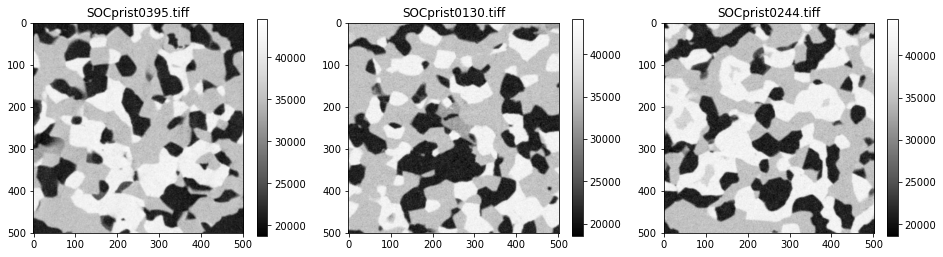

In [4]:
#Plot some tiffs to make sure the download was sucessful

data_path = os.path.join('example_data', 'experimental_data', 'SOCPristineTiffs')

tiffs = sorted(os.listdir(data_path))

fig, axes = plt.subplots(1,3,figsize=(16,4))
for ax in axes:
    random_tiff = tiffs[np.random.randint(len(tiffs))]
    image = plt.imread(os.path.join(data_path, random_tiff))
    im = ax.imshow(image, cmap='Greys_r')
    ax.set_title(random_tiff)
    fig.colorbar(im, ax=ax)

## 2. Investigate 1D and 2D histograms

To the left, you see the conventional intensity histogram of the data with one peak representing one phase in the data (pores, YSZ, Nikcel). The 2D BIMM is capturing the characteristic arc pattern seen in the 2D histogram of intensity and gradient magnitudes seen on the right. 

In [5]:
 #Load all tiffs, normalize intensities, and store intensities and gradient magnitudes in the 3D volume:
dataset = SOCPristineFor2Dmodel(data_path)

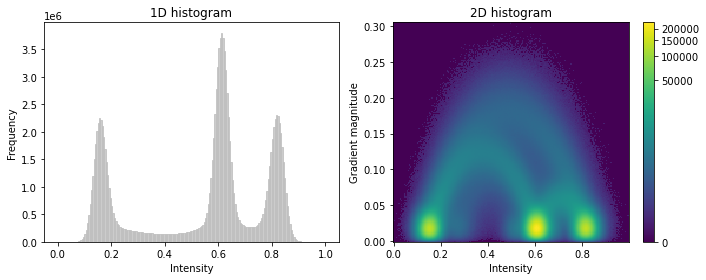

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
_ = tools.plot_1D_histogram(dataset.u.numpy(), bins = 200, fig_external = [fig, ax[0]],
                            xlabel='Intensity', title='1D histogram')
_ = tools.plot_2D_histogram(dataset.u.numpy(), dataset.v.numpy(), bins = 200, fig_external = [fig, ax[1]], 
                            title='2D histogram')

# 3. Fit the 2D BIMM

* n_ints: Number of iterations of optimization algoritm
* batch_size: number of datapoints per iteration
* nMC: Number of samples in Monte Carlo integration

Example: The following parameters takes approx. 10.5 minutes: 
```
n_its = 2000, batch_size = 50, nMC = 1000
```

In [7]:
n_its = 2000
batch_size = 50
nMC = 1000

n_phases = 3

In [8]:
############
## MODEL  ##
############

model = BIMM2D(n_phases)

In [9]:
print('Initial parameters:\n ')
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Initial parameters:
 
I 	 tensor([0.0000, 0.5000, 1.0000])
sigma_b 	 tensor(2.)
sigma_n 	 tensor(0.1000)
d 	 tensor(2.)
W 	 tensor([0., 0., 0., 0., 0., 0.])
r 	 tensor(0.)


In [10]:
################
## OPTIMIZER  ##
################

optimizer = torch.optim.Adadelta(model.parameters()) #DEFAULTS: lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

In [11]:
###########
## DATA  ##
###########

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True)

In [12]:
#####################
## TENSORBOARD LOG ##
#####################

logcomment = 'SOCPristine_test1'


timestamp = datetime.now().strftime("%b%d_%H-%M-%S-%f")
params_string = f' nMC={nMC} batch_size={batch_size} its={n_its} '
logfile = timestamp + params_string + ' comment=' + logcomment

print('Name of logfile: ', logfile)

logfile_path = os.path.join('example_log_experimental', logfile)

writer = SummaryWriter(log_dir=logfile_path)

Name of logfile:  Oct12_14-15-19-134760 nMC=1000 batch_size=50 its=2000  comment=SOCPristine_test1


In [13]:
##############
## FITTING  ##
##############

t_start_total = time.time()

for it, batch in enumerate(data_loader):
    t_start_it = time.time()

    #Log to tensorboard
    log_dict = tools.get_log_dict(model)
    tools.tb_log(writer, log_dict, it)

    loss = model(batch[0], batch[1], nMC)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #Log to tensorboard
    writer.add_scalar('loss/loss', loss, it)
    writer.flush()

    print('it:', it, 'of', n_its, 'its, %.3f s = %.2f min  total:  %.3f s = %.2f min '%( (time.time()-t_start_it), (time.time()-t_start_it)/60,(time.time()-t_start_total), (time.time()-t_start_total)/60),  end="\r")


    if torch.isnan(loss):
        print('Loss is NaN!')
        break

    if it>=n_its:
        break


In [14]:
print('Final parameters:\n ')
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Final parameters:
 
I 	 tensor([0.1583, 0.6124, 0.8203])
sigma_b 	 tensor(1.4543)
sigma_n 	 tensor(0.0258)
d 	 tensor(2.6498)
W 	 tensor([-0.0660,  0.4992, -0.0537, -0.2156, -0.7185, -0.4496])
r 	 tensor(0.5113)


### View optimization progress to judge convergence

If the optimizaiton has not converged, try to increase the number of iterations.

In [15]:
%tensorboard --logdir=example_log_experimental

### Get average of last iterations

Chose a run that has converged and use the average of the last `nvals_mean` iterations as the final parameters for our fitted model.

In [16]:
sorted(os.listdir('example_log_experimental'))

['Oct12_14-15-19-134760 nMC=1000 batch_size=50 its=2000  comment=SOCPristine_test1']

In [18]:
#choose the run you want to use for quantification and segmentation:
logfile_path = os.path.join('example_log_experimental', sorted(os.listdir('example_log_experimental'))[-1])

#get the mean of the last iterations:
nvals_mean = 500
avg_dict, std_dict = tools.get_mean_lastvals(logfile_path, nvals_mean)
avg_dict_formated = tools.log_to_params_dict(avg_dict)
avg_dict_formated

{'I': tensor([0.1589, 0.6116, 0.8220]),
 'w': tensor([0.1644, 0.3022, 0.1695, 0.1498, 0.0947, 0.1195]),
 'sigma_n': tensor(0.0274),
 'd': tensor(2.6101),
 'sigma_b': tensor(1.4529),
 'rho': tensor(0.4622)}

### Plot model VS 2D histogram

In [19]:
model.set_params(avg_dict_formated)

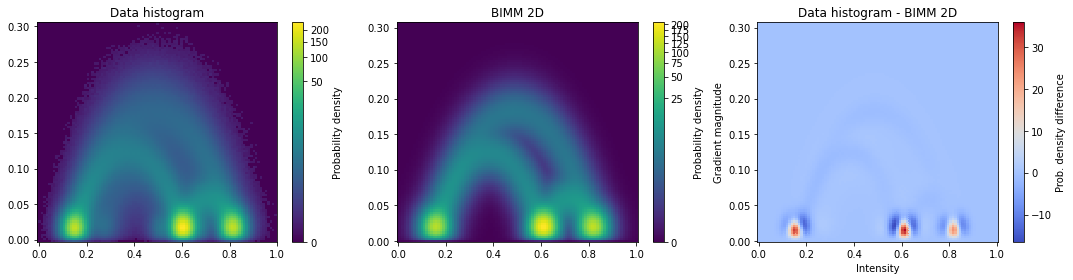

In [20]:
u_plot, v_plot = dataset.u.numpy(), dataset.v.numpy()
Ivals=np.linspace(np.min(u_plot), np.max(u_plot), 100)
Gvals=np.linspace(np.min(v_plot), np.max(v_plot), 100)
dI=Ivals[1]-Ivals[0]
dG=Gvals[1]-Gvals[0]

fig, ax = plt.subplots(1, 3, figsize = (15,4))

nbins_adj = np.concatenate([Ivals, np.array([(Ivals[-1]+dI)])])-0.5*dI, np.concatenate([Gvals, np.array([(Gvals[-1]+dG)])])-0.5*dG
im_data_hist = tools.plot_2D_histogram(u_plot, v_plot, cmap_gamma=0.2, fig_external = [fig, ax[0]],
                                       bins=nbins_adj, title='Data histogram', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density', density=True)

im_model_eval = tools.plot_2D_gridplot(model, Ivals, Gvals, n_MC_components=10000,  fig_external = [fig, ax[1]], cmap='viridis',
                       cmap_gamma=0.2, title='BIMM 2D', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density',axis='on')

tools.plot_2D_image(im_data_hist[0] - im_model_eval.T, cmap='coolwarm', colorbar =True,# vmin=-30, vmax=30, 
                    fig_external = [fig, ax[2]], xvals=Ivals, yvals=Gvals,
                    title='Data histogram - BIMM 2D',
                   xlabel='Intensity', ylabel='Gradient magnitude', cbar_label='Prob. density difference')


# 4. Quantification

The model parameters are directly linked to physical parameters of the sample and of the imaging process. 

See paper for an explanation of the model parameters.

| Physical parameter | Model parameter used in calculation (parameter explanation) |
| :- | :- | 
| Volume fractions |  $w$  (all model component weights)|
| Interface areas | $\sigma_b$ (blur level), $d$ (interface width), $w_{ij}$ (interface component weights) | 
| Image resolution | $\sigma_b$ (blur level) |
| Phase intensities  | $I$ (interior component means)|
| Noise level | $\sigma_n$ (interior component standard deviation) |
| Material non-homogenities | $\rho$ (correlation between voxels) | 

While the three last parameters are the can be read off from the model parameters directly, the three first are calculated using Eqs. (16), (17) and (18) in the [paper](https://arxiv.org/abs/2009.07218) [2]. Note that these value won't agree perfectly with the numbers reported in the paper, as we here only run the code once while for the paper, the code was run 30 times to calculate confidence intervals of the results. 


In [21]:
V1, V2, V3 = tools.get_V(avg_dict)

print('Volume fractions:')
print('Pores (black):  %.2f \n  YSZ (grey):     %.2f \n  Nickel (white): %.2f \n '%(V1, V2, V3))

voxelsize = 0.0184 #micro meter
A12, A13, A23 = tools.get_A(avg_dict, voxelsize)

print('Interface areas (μm²/μm³):')
print('Pores-Ni (black-grey):  %.2f  \n  Pores-Ni (black-white): %.2f \n  YSZ-Ni (grey-white):    %.2f \n '%(A12, A13, A23))


res1090 = tools.res1090(avg_dict_formated['sigma_b']*voxelsize*1000)
print('Image resolution (nm): \n %.2f'%(res1090) )

Volume fractions:
Pores (black):  0.29 
  YSZ (grey):     0.44 
  Nickel (white): 0.28 
 
Interface areas (μm²/μm³):
Pores-Ni (black-grey):  1.07  
  Pores-Ni (black-white): 0.68 
  YSZ-Ni (grey-white):    0.86 
 
Image resolution (nm): 
 68.52


# 5. Segmentation of a small data volume

Here, we perform a simple maximum-probability segmentation. That is, each voxels is classified according to which phase it has the highest probability to belong to, according to the model. This corresponds to thresholding in the 2D intensity - gradient magnitude space.


NB! Here, we only chose a small region of the data for segmentation to not fill up the RAM of a small computer. To segment the whole volume, a slice-by-slice or small cube-by-cube approach is recommended.




In [22]:
model.set_params(avg_dict_formated)

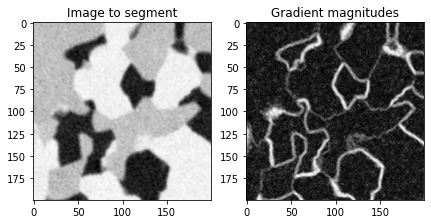

In [23]:
slice_no = 50
image_to_segment_u = np.reshape(dataset.u, dataset.shape)[0:200,:200,slice_no]
image_to_segment_v = np.reshape(dataset.v, dataset.shape)[0:200,:200,slice_no]
imsize_x, imsize_y = image_to_segment_u.shape

fig, ax = plt.subplots(1, 2, figsize = (7,5))
ax[0].imshow(image_to_segment_u, cmap='Greys_r')
ax[0].set_title('Image to segment')
ax[1].imshow(image_to_segment_v, cmap='Greys_r')
ax[1].set_title('Gradient magnitudes')
plt.show()


 Interface labels re-assigned to interior class accordint to image intensity: 



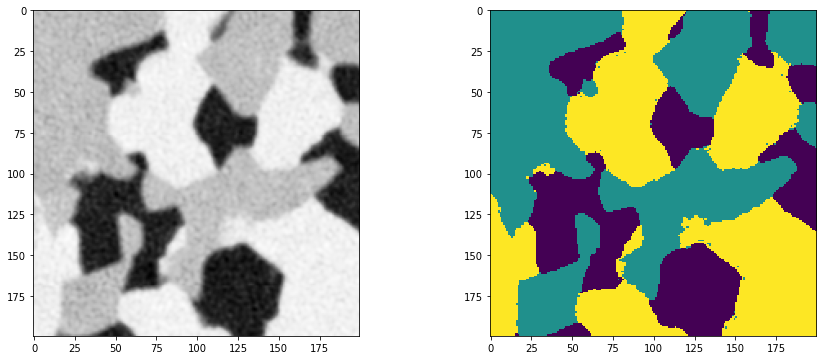

In [29]:
nMC_eval = 50
labeled_image = tools.evaluate_log_prob(model, image_to_segment_u, image_to_segment_v,  nMC_eval, n_labels = 3)

print('\n Interface labels re-assigned to interior class accordint to image intensity: \n')

fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].imshow(image_to_segment_u, cmap='Greys_r')
ax[1].imshow(labeled_image, cmap='viridis', interpolation='none')
plt.show()

### Scatter plot voxels to illustrate how labels are determined

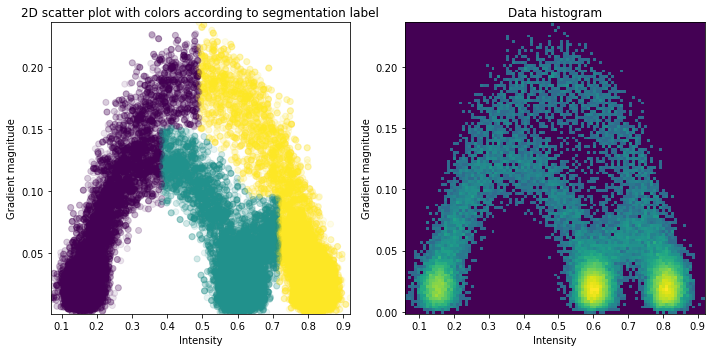

In [31]:
u_plot, v_plot = image_to_segment_u.numpy().ravel(), image_to_segment_v.numpy().ravel()
Ivals=np.linspace(np.min(u_plot), np.max(u_plot), 100)
Gvals=np.linspace(np.min(v_plot), np.max(v_plot), 100)
dI=Ivals[1]-Ivals[0]
dG=Gvals[1]-Gvals[0]

fig, ax = plt.subplots(1, 2, figsize = (10,5))
_ = tools.plot_2D_scatter_plot(u_plot, v_plot, colors = labeled_image.ravel(), 
                               n_samples = 100000, alpha = 0.1, xlim = [Ivals[0], Ivals[-1]], ylim = [Gvals[0], Gvals[-1]], fig_external = [fig, ax[0]],
                               xlabel='Intensity',ylabel='Gradient magnitude', title='2D scatter plot with colors according to segmentation label')

nbins_adj = np.concatenate([Ivals, np.array([(Ivals[-1]+dI)])])-0.5*dI, np.concatenate([Gvals, np.array([(Gvals[-1]+dG)])])-0.5*dG
im_data_hist = tools.plot_2D_histogram(u_plot, v_plot, cmap_gamma=0.2, fig_external = [fig, ax[1]],
                                       bins=nbins_adj, title='Data histogram', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density', density=True, colorbar = False)

## Segmentation according to model component

Looking at how the model classifies each voxel: Interphase or phase interior?



 All labels - one per model component 



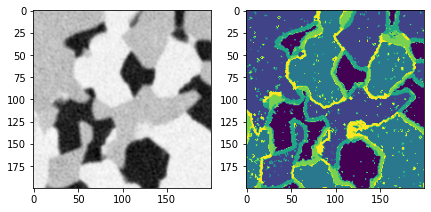

In [25]:
nMC_eval = 50
labeled_image = tools.evaluate_log_prob(model, image_to_segment_u, image_to_segment_v, nMC_eval, n_labels = 6)

print('\n All labels - one per model component \n')

fig, ax = plt.subplots(1, 2, figsize = (7,4))
ax[0].imshow(image_to_segment_u, cmap='Greys_r')
ax[1].imshow(labeled_image, cmap='viridis')
plt.show()

### Scatter plot voxels to illustrate how labels are determined

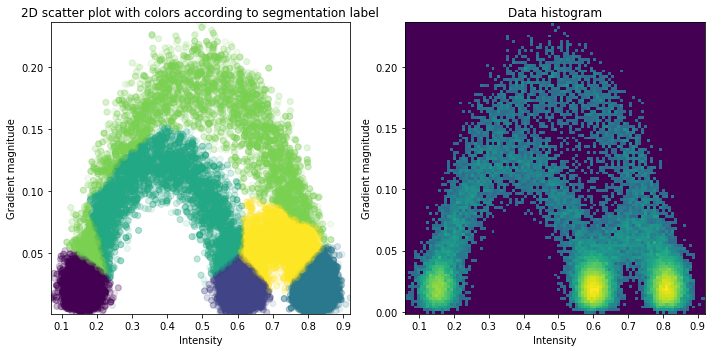

In [28]:
u_plot, v_plot = image_to_segment_u.numpy().ravel(), image_to_segment_v.numpy().ravel()
Ivals=np.linspace(np.min(u_plot), np.max(u_plot), 100)
Gvals=np.linspace(np.min(v_plot), np.max(v_plot), 100)
dI=Ivals[1]-Ivals[0]
dG=Gvals[1]-Gvals[0]

fig, ax = plt.subplots(1, 2, figsize = (10,5))
_ = tools.plot_2D_scatter_plot(u_plot, v_plot, colors = labeled_image.ravel(), 
                               n_samples = 100000, alpha = 0.1, xlim = [Ivals[0], Ivals[-1]], ylim = [Gvals[0], Gvals[-1]], fig_external = [fig, ax[0]],
                               xlabel='Intensity',ylabel='Gradient magnitude', title='2D scatter plot with colors according to segmentation label')

nbins_adj = np.concatenate([Ivals, np.array([(Ivals[-1]+dI)])])-0.5*dI, np.concatenate([Gvals, np.array([(Gvals[-1]+dG)])])-0.5*dG
im_data_hist = tools.plot_2D_histogram(u_plot, v_plot, cmap_gamma=0.2, fig_external = [fig, ax[1]],
                                       bins=nbins_adj, title='Data histogram', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density', density=True, colorbar = False)